In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.interpolate import interp1d, interp2d

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from ipywidgets import interact, IntSlider

# Preparation

In [2]:
from read_results import read_varnames
import strato_code.kpp4py as kpp

nvar = 34
varnames = read_varnames("strato_code/strato_Parameters.f90")[0:nvar]
print(varnames)

['CH3', 'Cl2', 'Cl2O2', 'ClOO', 'OClO', 'BrCl', 'HOBr', 'BrONO2', 'HCO', 'CH3O', 'O1D', 'N2O5', 'HBr', 'CH3OOH', 'HNO4', 'HCl', 'H2O2', 'HOCl', 'HNO3', 'H', 'CH3O2', 'ClONO2', 'NO3', 'CH2O', 'Br', 'OH', 'Cl', 'ClO', 'O3', 'NO', 'BrO', 'O', 'HO2', 'NO2']


In [3]:
df_range = (
    pd.read_csv('strato_range.csv', index_col=0)
    .append(pd.DataFrame(np.array([[0.0, 1.0]]), 
                         columns=['min','max'], 
                         index=['SUN']
                        )
           )
)

df_range['mid'] = 0.5*(df_range['min']+df_range['max'])
df_range.tail(10)

,min,max,mid
OH,3.791087e+01,1.655987e+07,8.279952e+06
Cl,7.667911e-01,7.642127e+05,3.821067e+05
ClO,2.236826e+07,8.342272e+07,5.289549e+07
O3,4.342945e+11,5.292275e+11,4.817610e+11
NO,1.000000e-08,8.828713e+08,4.414357e+08
BrO,1.096853e+04,9.603792e+05,4.856739e+05
O,1.000000e-08,6.590324e+08,3.295162e+08
HO2,9.779919e+02,1.166693e+07,5.833955e+06
NO2,2.134505e+08,1.066423e+09,6.399367e+08
SUN,0.000000e+00,1.000000e+00,5.000000e-01


## 0-th order

In [4]:
x0 = df_range['mid'].values
f0 = y0 = kpp.onestep(x0.T).T
x0.shape, y0.shape

((35,), (1, 34))

## 1-st orer

In [5]:
@interact(n=IntSlider(min=0,max=34,step=1,value=29,continuous_update=False))
def plot_1d(n):
    res = 20 # resolution

    x_list = np.empty([res, nvar+1])
    x_list[:] = df_range['mid'].values

    x_list[:,n] = np.linspace(df_range['min'][n],df_range['max'][n], res)

    y = kpp.onestep(x_list.T).T
    plt.plot(x_list[:,n], y/y0-1)
    plt.ylim(-1,1)
    plt.show()

In [6]:
def hdmr_axis(n, res = 20):
    '''Sample along one axis'''
    x_list = np.empty([res, nvar+1])
    x_list[:] = df_range['mid'].values
    x_list[:,n] = np.linspace(df_range['min'][n],df_range['max'][n], res)

    y1 = kpp.onestep(x_list.T).T - y0
    return y1, x_list[:,n]

In [7]:
# construct all 1-st order components
y1_list = [None]*(nvar+1)
x1_list = [None]*(nvar+1)

for n in range(nvar+1):
    y1_list[n], x1_list[n] = hdmr_axis(n)

## Interpolate

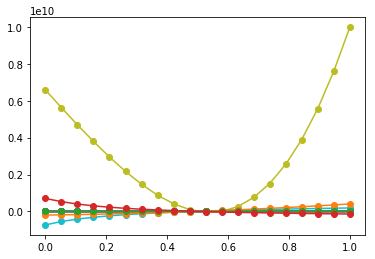

In [8]:
j_in = 34
plt.plot(x1_list[j_in], y1_list[j_in], '-o');

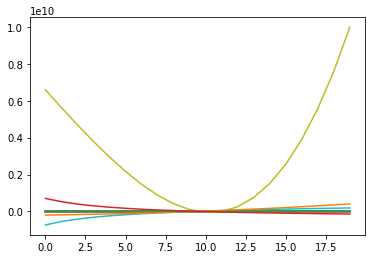

In [9]:
f = interp1d(x1_list[j_in], y1_list[j_in].T)
plt.plot(f(x1_list[j_in]).T);

In [10]:
# interpolate all HDMR components
f1 = []
for j_in in range(nvar+1):
    f1.append( interp1d(x1_list[j_in], y1_list[j_in].T) )

In [11]:
j_in = 6
f1[j_in](df_range['mid'][j_in])/f0

array([[  2.87744803e-10,   1.80894204e-09,  -7.64989057e-10,
          5.03066296e-10,  -1.04866548e-07,  -1.11160028e-07,
          1.50939596e-07,   3.99073993e-08,   2.11288340e-10,
          1.40202960e-10,   2.03211956e-11,  -2.05642301e-12,
          1.99992558e-08,   2.31498199e-10,  -5.76068891e-10,
          5.36381259e-11,  -4.04814064e-11,  -1.77781043e-09,
         -2.55417338e-10,   2.18929210e-10,   1.28579612e-10,
         -1.58176009e-11,   2.59780434e-10,   1.69456303e-10,
         -7.99120838e-08,   2.20570101e-10,   5.31360714e-10,
          3.73373589e-10,   2.03217264e-11,   2.68025922e-10,
         -6.22795895e-08,   1.20014406e-11,   1.71038848e-11,
         -5.14024201e-10]])

In [12]:
j_in = 6
f1[j_in](np.linspace(df_range['max'][j_in], df_range['max'][j_in], 10)).shape

(34, 10)

In [13]:
def eval_hdmr1(x, f0=f0, f1=f1):
    '''Evaluate 1-st order HDMR at x'''
    S = 0.0 # to hold the sum of all components
    
    # 1-st order components
    for j_in in range(nvar+1):
        S += f1[j_in](x[:,j_in]).T
    
    # 0-th order term
    S += f0
    return S

## Test set

In [14]:
df_range['span'] = df_range['max'] - df_range['min']

In [15]:
#x_test = np.random.uniform(df_range['min'], df_range['max'], size=(5000, nvar+1))

x_test = np.random.uniform(df_range['min'] + 0.0*df_range['span'],
                           df_range['max'] - 0.0*df_range['span'], 
                           size=(5000, nvar+1))

x_test.shape

(5000, 35)

In [16]:
%time y_test_pred = eval_hdmr1(x_test)
y_test_pred.shape

CPU times: user 67.3 ms, sys: 8.57 ms, total: 75.8 ms
Wall time: 61 ms


(5000, 34)

In [17]:
%time y_test_true = kpp.onestep(x_test.T).T
y_test_true.shape

CPU times: user 1.36 s, sys: 13.4 ms, total: 1.37 s
Wall time: 1.37 s


(5000, 34)

In [18]:
r2_score(y_test_pred, y_test_true)

0.87696959292615251

In [19]:
r2_score(y_test_pred/df_range['max'][:-1].values, 
         y_test_true/df_range['max'][:-1].values)

0.8769695929261524

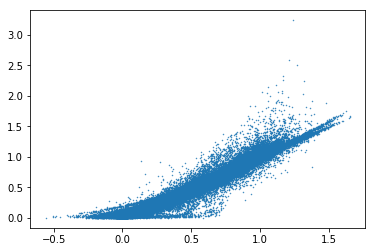

In [20]:
plt.scatter(y_test_pred/df_range['max'][:-1].values, 
            y_test_true/df_range['max'][:-1].values,
            s=0.2)

# Second-order components

In [24]:
@interact(n=IntSlider(min=0,max=34,step=1,value=21,continuous_update=False),
          m=IntSlider(min=0,max=34,step=1,value=27,continuous_update=False),
          k=IntSlider(min=0,max=33,step=1,value=33,continuous_update=False))
def plot_2d(n, m, k):
    res = 20 # resolution

    range_n = np.linspace(df_range['min'][n], df_range['max'][n], res)
    range_m = np.linspace(df_range['min'][m], df_range['max'][m], res)

    x_list = np.empty([res, res, nvar+1])
    x_list[:] = df_range['mid'].values
    x_list[:,:,n] = range_n.reshape(1,res)
    x_list[:,:,m] = range_m.reshape(res,1)

    y = kpp.onestep(x_list.reshape(res*res,-1).T).T
    
    plt.pcolormesh(range_n, range_m, y.reshape(res,res,-1)[...,k])
    plt.xlabel(df_range.iloc[n].name)
    plt.ylabel(df_range.iloc[m].name)
    plt.title(df_range.iloc[k].name)
    plt.show()